In [1]:
normalizedScores = {("b6e71c034fa5e34b5d8a9199208d53cb", 76): 0.3, ("b6e71c034fa5e34b5d8a9199208d53cb", 176): 0.85, ("b6e71c034fa5e34b5d8a9199208d53cb", 85): 0.4}
powers = {176:0.5, 76:0.9, 85:0.8}
def getIntegratedAdomniScore(normalizedScores, powers):
    integratedAdomniScore = 0
    for locationhash_and_segId in normalizedScores:
        integratedAdomniScore = integratedAdomniScore + normalizedScores[locationhash_and_segId] * powers[locationhash_and_segId[1]] 
    return integratedAdomniScore/len(normalizedScores)

getIntegratedAdomniScore(normalizedScores, powers)

0.3383333333333334

In [2]:
import json
with open('DynamoDBtoCSV-master/config.json') as f:
    Tuo_authentications = json.load(f)

In [3]:
import boto3
def run_query(query, s3_output):
    client = boto3.client('athena',
                           aws_access_key_id = Tuo_authentications['accessKeyId'],
                           aws_secret_access_key = Tuo_authentications['secretAccessKey'],
                           region_name = Tuo_authentications["region"])
    response = client.start_query_execution(
        QueryString = query,
        QueryExecutionContext = {
          'Database': 'default'
        },
        ResultConfiguration = {
            'OutputLocation': s3_output,
            'EncryptionConfiguration': {
                'EncryptionOption': 'SSE_S3'
            }
        }
        
    )
    print('Execution ID: ' + response['QueryExecutionId'])
    return response


s3_output = 's3://tuo-bucket/playing'

query = "select * from adomni_audience_segment where id='{ID}';"

params = {"ID":"740"}

QueryResponse = run_query(query.format(**params), s3_output)
print(QueryResponse)
QueryExecutionId = QueryResponse['QueryExecutionId']

Execution ID: c728127c-f217-47ff-adc9-dc268e3f7043
{'QueryExecutionId': 'c728127c-f217-47ff-adc9-dc268e3f7043', 'ResponseMetadata': {'RequestId': 'dadfdfaa-1628-4048-a8fb-585b55415d57', 'HTTPStatusCode': 200, 'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1', 'date': 'Wed, 27 Nov 2019 22:13:31 GMT', 'x-amzn-requestid': 'dadfdfaa-1628-4048-a8fb-585b55415d57', 'content-length': '59', 'connection': 'keep-alive'}, 'RetryAttempts': 0}}


In [4]:
import json
with open('DynamoDBtoCSV-master/config.json') as f:
    Tuo_authentications = json.load(f)

import boto3
from boto3.dynamodb.conditions import Key, Attr

dynamodb = boto3.resource('dynamodb',
                           aws_access_key_id = Tuo_authentications['accessKeyId'],
                           aws_secret_access_key = Tuo_authentications['secretAccessKey'],
                           region_name = Tuo_authentications["region"]
)


table = dynamodb.Table('machine_learning')

# rs = list(table.scan(ExclusiveStartKey = 'b01186c0cdbde739e62d794f13792c36623'))
# for i in rs:
#     print(i['primarykey'])


In [5]:
response = table.query(
    KeyConditionExpression=Key('billboard_audience_segment_id').eq('b01186c0cdbde739e62d794f13792c36623')
)
# print(response)
data = response['Items']

In [6]:
import pandas as pd
df = pd.DataFrame(data)
print(df)

   week_of_year               count        date  \
0             0                 2.0  2018-12-31   
1             1                 2.0  2019-01-07   
2            10                 2.0  2019-03-11   
3            11                 2.0  2019-03-18   
4            12                 2.0  2019-03-25   
5            13                 2.0  2019-04-01   
6            14                 2.0  2019-04-08   
7            15                 2.0  2019-04-15   
8            16                 2.0  2019-04-22   
9            17                 2.0  2019-04-29   
10           18                 2.0  2019-05-06   
11           19  2.0714285714285716  2019-05-13   
12            2                 2.0  2019-01-14   
13           20                 2.0  2019-05-13   
14           21   2.142857142857143  2019-05-27   
15           22  2.2142857142857144  2019-06-03   
16           23  2.2857142857142856  2019-06-10   
17           24   2.357142857142857  2019-06-17   
18           25  2.428571428571

In [7]:
training_set = df.iloc[:,1].values
training_set = [[float(i)] for i in training_set]
print(training_set)

[[2.0], [2.0], [2.0], [2.0], [2.0], [2.0], [2.0], [2.0], [2.0], [2.0], [2.0], [2.0714285714285716], [2.0], [2.0], [2.142857142857143], [2.2142857142857144], [2.2857142857142856], [2.357142857142857], [2.4285714285714284], [2.5], [2.571428571428571], [2.642857142857143], [2.7142857142857144], [2.0], [2.7857142857142856], [2.857142857142857], [2.9285714285714284], [3.0], [2.75], [2.5], [2.25], [2.0], [1.6666666666666667], [1.3333333333333335], [2.0], [1.0], [3.0], [4.0], [3.0], [2.0], [2.0], [2.0], [2.0], [2.0], [2.0], [2.0], [2.0], [2.0], [2.0], [2.0], [2.0], [2.0], [2.0]]


In [8]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 20
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))


In [9]:


class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [10]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.71380
Epoch: 100, loss: 0.04574
Epoch: 200, loss: 0.04399
Epoch: 300, loss: 0.04214
Epoch: 400, loss: 0.04032
Epoch: 500, loss: 0.03876
Epoch: 600, loss: 0.03759
Epoch: 700, loss: 0.03674
Epoch: 800, loss: 0.03609
Epoch: 900, loss: 0.03553
Epoch: 1000, loss: 0.03499
Epoch: 1100, loss: 0.03445
Epoch: 1200, loss: 0.03388
Epoch: 1300, loss: 0.03326
Epoch: 1400, loss: 0.03261
Epoch: 1500, loss: 0.03192
Epoch: 1600, loss: 0.03119
Epoch: 1700, loss: 0.03043
Epoch: 1800, loss: 0.02967
Epoch: 1900, loss: 0.02892


32


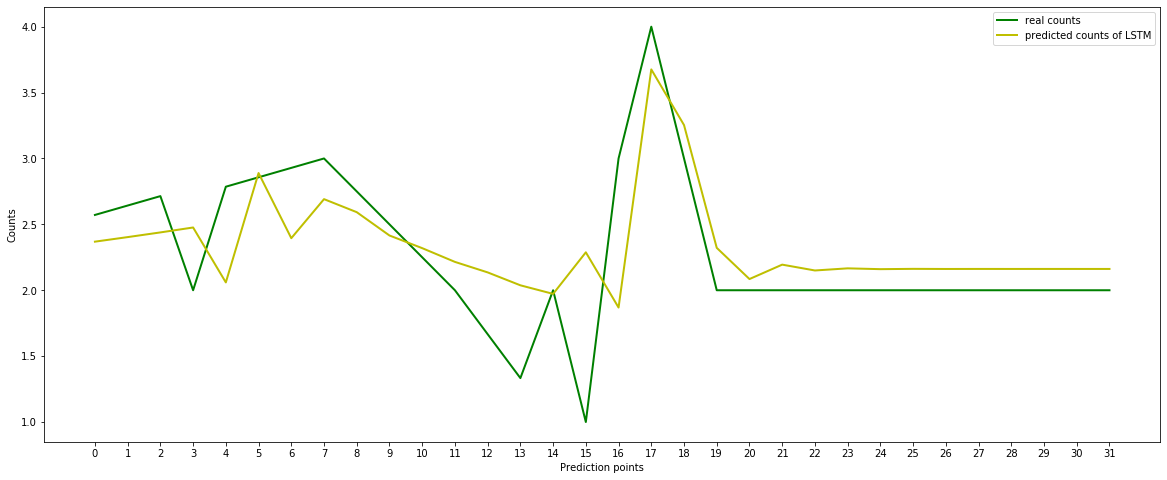

In [11]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(20,8))

print(len(dataX))
plt.plot(dataY_plot, "g", label="real counts", linewidth=2.0)
plt.plot(data_predict, "y", label="predicted counts of LSTM", linewidth=2.0)


plt.xticks(range(len(dataY_plot)))
plt.xlabel('Prediction points')
plt.ylabel('Counts')
plt.legend(loc="best")
# plt.suptitle('Time-Series Prediction')
plt.savefig("Time-Series Prediction.png")
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(dataY_plot, data_predict)
print("RMSE:", np.sqrt(mse))

RMSE: 0.41923645


In [20]:
def sliding_final_windows(data, seq_length):
    x = []

    _x = data[len(data) - seq_length:len(data)]
    x.append(_x)

    return np.array(x)

In [25]:
final_x = sliding_final_windows(training_data, seq_length)
final_dataX = Variable(torch.Tensor(np.array(final_x)))

final_train_predict = lstm(final_dataX)

In [26]:
print(final_dataX)

tensor([[[0.1111],
         [0.3333],
         [0.0000],
         [0.6667],
         [1.0000],
         [0.6667],
         [0.3333],
         [0.3333],
         [0.3333],
         [0.3333],
         [0.3333],
         [0.3333],
         [0.3333],
         [0.3333],
         [0.3333],
         [0.3333],
         [0.3333],
         [0.3333],
         [0.3333],
         [0.3333]]])


In [27]:
print(sc.inverse_transform(final_train_predict.data.numpy()))

[[2.1617115]]


In [ ]:
import LSTM

print(LSTM.get_predicted_count('b01186c0cdbde739e62d794f13792c3662','3'))